In [367]:
import pandas_datareader 
import datetime
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import pandas as pd
from pandas.plotting import scatter_matrix
from matplotlib.finance import candlestick_ohlc
from matplotlib.dates import DateFormatter, date2num, WeekdayLocator, DayLocator, MONDAY
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA

start= datetime.datetime(2012,1,1)
finish= datetime.datetime(2018,1,1)
%matplotlib inline

In [368]:
# Store in a function for later use!
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [369]:
sp500 = pd.read_csv('sp500.csv',parse_dates=True, index_col="Date",usecols=["Date", "Adj Close"], na_values=["nan"])

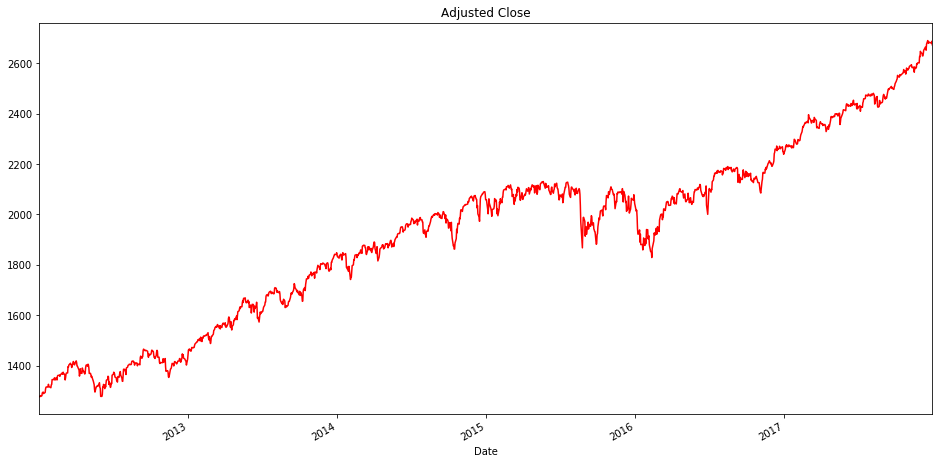

In [370]:
sp500['Adj Close'].plot(figsize=(16,8), color='r', label='Sp500', title='Adjusted Close')


In [371]:
sp500['Adj Close'].describe()

count    1509.000000
mean     1926.933082
std       351.356105
min      1277.060059
25%      1650.510010
50%      1986.510010
75%      2124.290039
max      2690.159912
Name: Adj Close, dtype: float64

              Adj Close        trend      cycle
Date                                           
2012-01-03  1277.060059  1280.984492  -3.924433
2012-01-04  1277.300049  1283.539276  -6.239227
2012-01-05  1281.060059  1286.093968  -5.033909
2012-01-06  1277.810059  1288.648334 -10.838275
2012-01-09  1280.699951  1291.202023 -10.502072


Text(0.5,1,'Trend Component SP500')

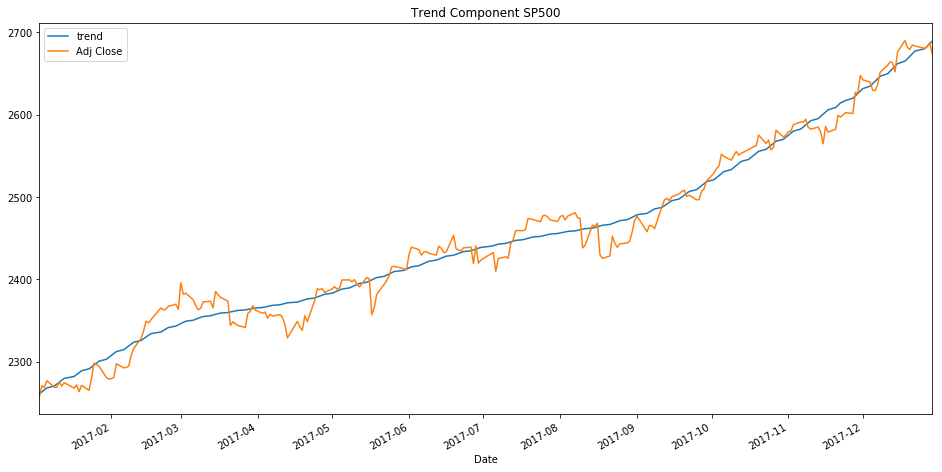

In [372]:
### TIME SERIES ANALISYS TREND AND CYCLE STATMODELS

gdp_cycle, gdp_trend = sm.tsa.filters.hpfilter(sp500['Adj Close'],43200)# lamda for daily 43200  http://mycroft2b.com/trend-line-hodrick-prescott-filter/

sp500["trend"] = gdp_trend
sp500["cycle"] = gdp_cycle
print(sp500.head())
sp500[['trend','Adj Close']]["2017-01-03":].plot(figsize=(16,8))
plt.title("Trend Component SP500")


In [373]:
sp500.tail()

,Adj Close,trend,cycle
Date,,,
2017-12-22,2683.340088,2677.100141,6.239947
2017-12-26,2680.500000,2680.143553,0.356447
2017-12-27,2682.620117,2683.185925,-0.565808
2017-12-28,2687.540039,2686.227603,1.312436
2017-12-29,2673.610107,2689.268918,-15.658811


Text(0.5,1,'CyCle Component SP500')

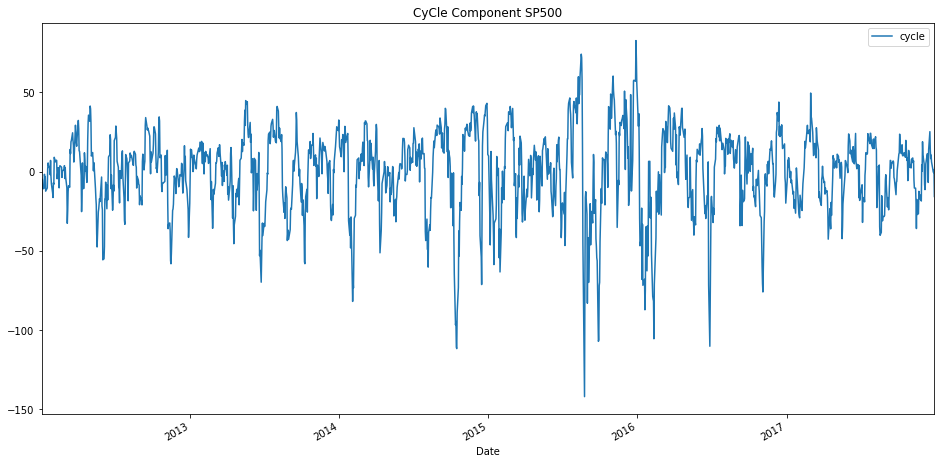

In [374]:
sp500[['cycle']].plot(figsize=(16,8))
plt.title("CyCle Component SP500")

Text(0.5,1,'EWMA and Rolling Mean 21 & 63 Days SP500')

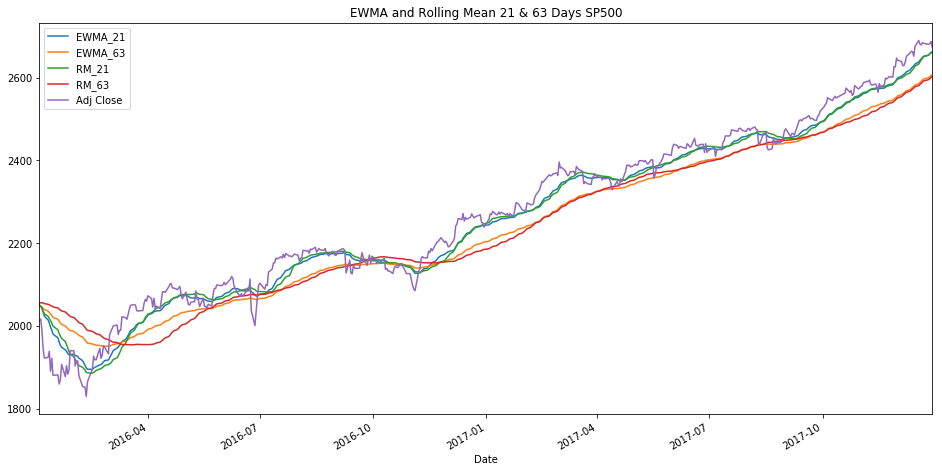

In [375]:
### Exponential Weightied AVerage

#sp500["RM_5"] = sp500['Adj Close'].rolling(window=5).mean()
sp500["RM_21"] = sp500['Adj Close'].rolling(window=21).mean()
sp500["RM_63"] = sp500['Adj Close'].rolling(window=63).mean()

#sp500["EWMA_5"] = sp500['Adj Close'].ewm(span=5).mean()
sp500["EWMA_21"] = sp500['Adj Close'].ewm(span=21).mean()
sp500["EWMA_63"] = sp500['Adj Close'].ewm(span=63).mean()


#sp500[["EWMA_5","EWMA_21","EWMA_63","RM_5","RM_21","RM_63",'Adj Close']]["2016-01-01":].plot(figsize=(12,6))
sp500[["EWMA_21","EWMA_63","RM_21","RM_63",'Adj Close']]["2016-01-01":].plot(figsize=(16,8))
plt.title("EWMA and Rolling Mean 21 & 63 Days SP500")

Text(0.3,1,'ETS Decomposition Multiplicative model SP500')

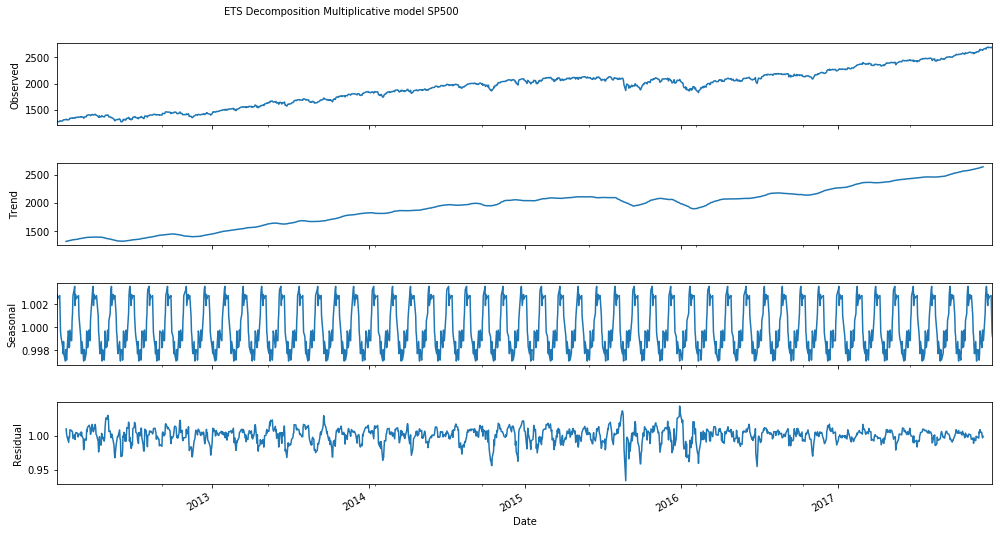

In [376]:
### ETS-Decomposition
result = seasonal_decompose(sp500[['Adj Close']], model='multiplicative',freq=30)
picture=result.plot()
picture.set_size_inches(16,8)
picture.text(0.3,1,"ETS Decomposition Multiplicative model SP500")


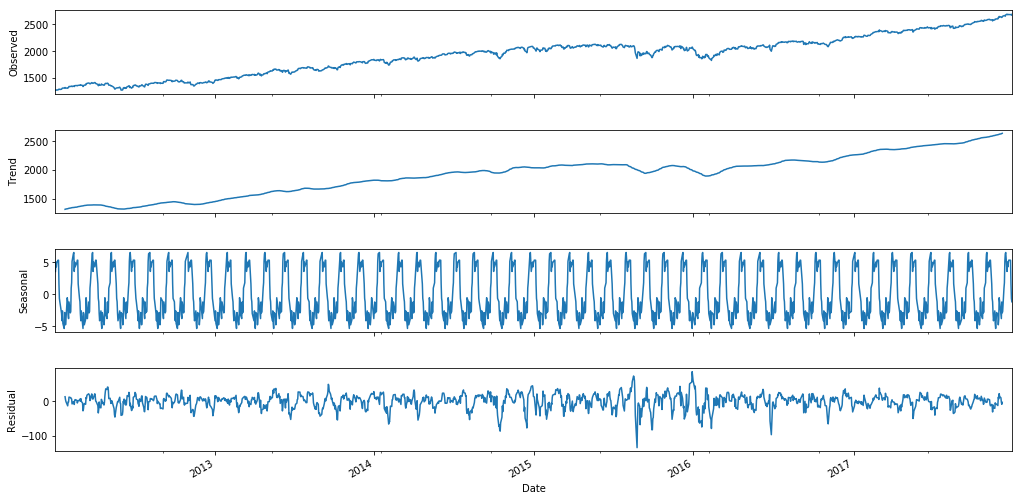

In [377]:
### ETS-Decomposition
result = seasonal_decompose(sp500[['Adj Close']], model='additive',freq=30)
picture=result.plot()
picture.set_size_inches(16,8)


Augmented Dickey-Fuller Test:
ADF Test Statistic : -0.2830458788287983
p-value : 0.9278714562613439
#Lags Used : 4
Number of Observations Used : 1504
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


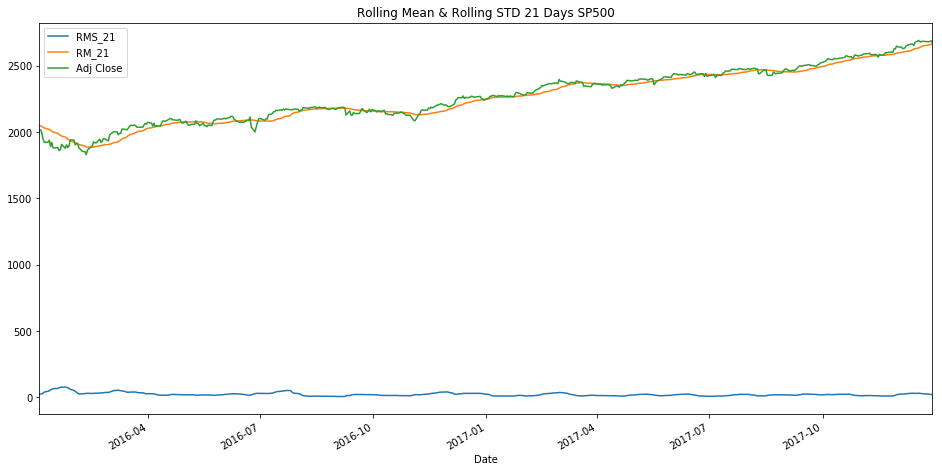

In [378]:
### ARIMA MODEL

sp500["RM_21"] = sp500['Adj Close'].rolling(window=21).mean()
sp500["RMS_21"] = sp500['Adj Close'].rolling(window=21).std()
sp500[["RMS_21","RM_21",'Adj Close']]["2016-01-01":].plot(figsize=(16,8))
plt.title("Rolling Mean & Rolling STD 21 Days SP500")

result = adf_check(sp500['Adj Close'])

First Diff

Augmented Dickey-Fuller Test:
ADF Test Statistic : -21.406568516254143
p-value : 0.0
#Lags Used : 3
Number of Observations Used : 1504
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary

Second Diff

Augmented Dickey-Fuller Test:
ADF Test Statistic : -15.37162605977802
p-value : 3.5021966940813093e-28
#Lags Used : 22
Number of Observations Used : 1484
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


Text(0.5,1,'sp500 Second Difference')

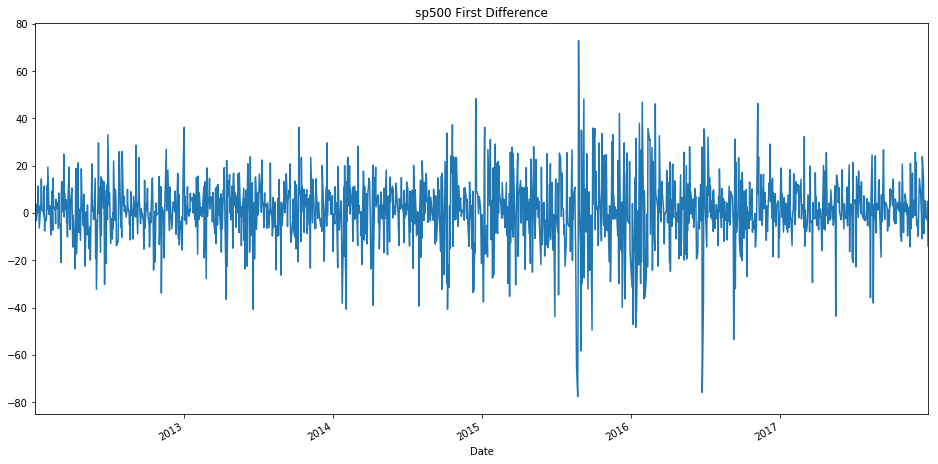

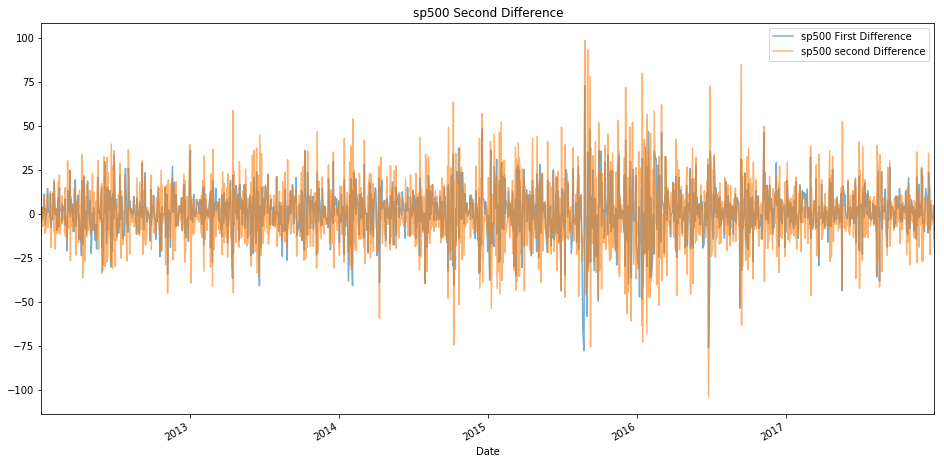

In [379]:
### ARIMA Diffrenciating


print("First Diff\n")
sp500['sp500 First Difference'] = sp500['Adj Close'] - sp500['Adj Close'].shift(1)
result = adf_check(sp500['sp500 First Difference'].dropna())

sp500['sp500 First Difference'].plot(figsize=(16,8))
plt.title("sp500 First Difference")

sp500['sp500 second Difference'] = sp500['sp500 First Difference'] - sp500['sp500 First Difference'].shift(1)
print("\nSecond Diff\n")
result = adf_check(sp500['sp500 second Difference'].dropna())
sp500[["sp500 First Difference", "sp500 second Difference"]].plot(figsize=(16,8),alpha=0.6)
plt.title("sp500 Second Difference")





Seasonal 254 ADF TEST 

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.0612390474503184
p-value : 0.26038336227496256
#Lags Used : 4
Number of Observations Used : 1250
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


Seasonal Different ADF Test 

Augmented Dickey-Fuller Test:
ADF Test Statistic : -19.6104021009271
p-value : 0.0
#Lags Used : 3
Number of Observations Used : 1250
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


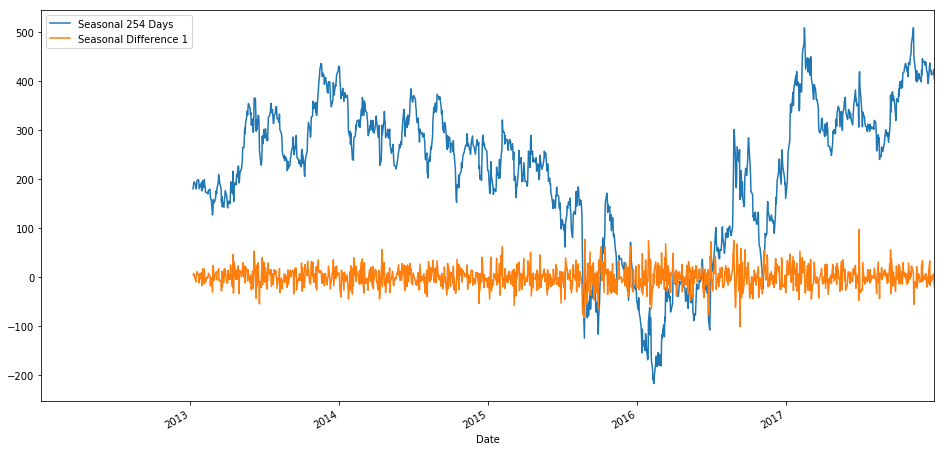

In [380]:
## Seasonality  lag of 254 observations = 1 year

sp500['sp500 seasonal'] =  sp500['Adj Close'] - sp500['Adj Close'].shift(254)
print("\n\nSeasonal 254 ADF TEST \n")
result = adf_check(sp500['sp500 seasonal'].dropna())
figure=sp500['sp500 seasonal'].plot(figsize=(16,8), label="Seasonal 254 Days")
#plt.savefig('sp500 seasonal 254 days.png')

sp500['sp500 seasonal 1Diff']= sp500['sp500 seasonal'] -sp500['sp500 seasonal'].shift(1)
print("\n\nSeasonal Different ADF Test \n")
result = adf_check(sp500['sp500 seasonal 1Diff'].dropna())

figure=sp500['sp500 seasonal 1Diff'].plot(figsize=(16,8),label="Seasonal Difference 1")
plt.legend()
#plt.savefig('sp500 seasonal 254 days 1 diff.png')


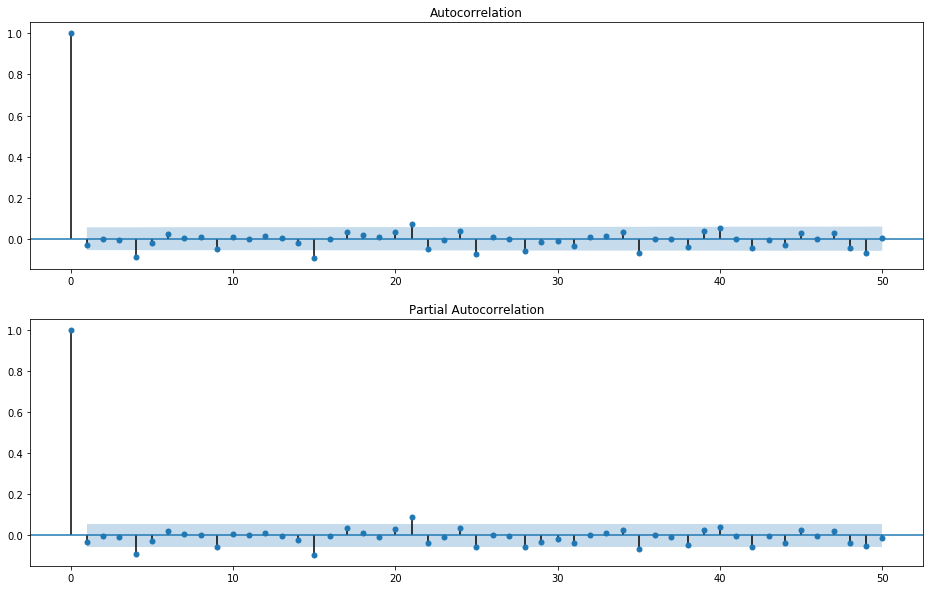

In [381]:
#autocorrelation_plot(sp500['sp500 seasonal 1Diff'].dropna())

fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sp500['sp500 seasonal 1Diff'].iloc[260:], lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sp500['sp500 seasonal 1Diff'].iloc[260:], lags=50, ax=ax2)

In [382]:
help(ARIMA)

Help on class ARIMA in module statsmodels.tsa.arima_model:

class ARIMA(ARMA)
 |  Autoregressive Integrated Moving Average ARIMA(p,d,q) Model
 |  
 |  Parameters
 |  ----------
 |  endog : array-like
 |      The endogenous variable.
 |  order : iterable
 |      The (p,d,q) order of the model for the number of AR parameters,
 |      differences, and MA parameters to use.
 |  exog : array-like, optional
 |      An optional array of exogenous variables. This should *not* include a
 |      constant or trend. You can specify this in the `fit` method.
 |  dates : array-like of datetime, optional
 |      An array-like object of datetime objects. If a pandas object is given
 |      for endog or exog, it is assumed to have a DateIndex.
 |  freq : str, optional
 |      The frequency of the time-series. A Pandas offset or 'B', 'D', 'W',
 |      'M', 'A', or 'Q'. This is optional if dates are given.
 |  
 |  
 |  Notes
 |  -----
 |  If exogenous variables are given, then the model that is fit is
 

In [384]:
# https://pandas.pydata.org/pandas-docs/stable/timeseries.html
# Alternatives 
# pd.date_range(df.index[-1],periods=12,freq='M')
from pandas.tseries.offsets import DateOffset

In [ ]:
#sp500.index

In [ ]:
#future_dates = [sp500.index[-1] + DateOffset(days=x) for x in range(0,180) ]

In [ ]:
#future_dates

In [388]:
start= datetime.datetime(2018,1,1)
finish= datetime.datetime(2018,6,30)
sp500_new = web.DataReader('^GSPC','yahoo',start,finish)

In [389]:
sp500_new['Adj Close'].tail()

Date
2018-06-25    2717.070068
2018-06-26    2723.060059
2018-06-27    2699.629883
2018-06-28    2716.310059
2018-06-29    2718.370117
Name: Adj Close, dtype: float64

In [390]:
sp500_new['Adj Close'].describe()

count     125.000000
mean     2717.939838
std        61.561031
min      2581.000000
25%      2670.290039
50%      2720.939941
75%      2754.879883
max      2872.870117
Name: Adj Close, dtype: float64

In [391]:
future_dates_sp500 = pd.DataFrame(index=sp500_new.index,columns=sp500.columns)

In [392]:
future_dates_sp500.tail()

,Adj Close,trend,cycle,RM_21,RM_63,EWMA_21,EWMA_63,RMS_21,sp500 First Difference,sp500 second Difference,sp500 seasonal,sp500 seasonal 1Diff
Date,,,,,,,,,,,,
2018-06-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [393]:
sp500.tail()

,Adj Close,trend,cycle,RM_21,RM_63,EWMA_21,EWMA_63,RMS_21,sp500 First Difference,sp500 second Difference,sp500 seasonal,sp500 seasonal 1Diff
Date,,,,,,,,,,,,
2017-12-22,2683.340088,2677.100141,6.239947,2650.812872,2592.309539,2652.134103,2597.144291,26.273759,-1.229980,-6.550048,412.580078,-9.459961
2017-12-26,2680.500000,2680.143553,0.356447,2654.530971,2595.224776,2654.712821,2599.749157,24.551321,-2.840088,-1.610108,415.320068,2.739990
2017-12-27,2682.620117,2683.185925,-0.565808,2658.397647,2598.011761,2657.249848,2602.338874,22.033598,2.120117,4.960205,421.660156,6.340088
2017-12-28,2687.540039,2686.227603,1.312436,2661.278599,2600.828904,2660.003502,2605.001410,21.680949,4.919922,2.799805,423.750000,2.089844
2017-12-29,2673.610107,2689.268918,-15.658811,2663.542411,2603.277317,2661.240466,2607.145432,20.255955,-13.929932,-18.849854,404.730224,-19.019776


In [394]:
colums=sp500.columns
print(colums)

Index(['Adj Close', 'trend', 'cycle', 'RM_21', 'RM_63', 'EWMA_21', 'EWMA_63',
       'RMS_21', 'sp500 First Difference', 'sp500 second Difference',
       'sp500 seasonal', 'sp500 seasonal 1Diff'],
      dtype='object')


In [520]:
sp500=sp500_seg.copy() 
sp500.tail()

,Adj Close,trend,cycle,RM_21,RM_63,EWMA_21,EWMA_63,RMS_21,sp500 First Difference,sp500 second Difference,sp500 seasonal,sp500 seasonal 1Diff
Date,,,,,,,,,,,,
2017-12-22,2683.340088,2677.100141,6.239947,2650.812872,2592.309539,2652.134103,2597.144291,26.273759,-1.229980,-6.550048,412.580078,-9.459961
2017-12-26,2680.500000,2680.143553,0.356447,2654.530971,2595.224776,2654.712821,2599.749157,24.551321,-2.840088,-1.610108,415.320068,2.739990
2017-12-27,2682.620117,2683.185925,-0.565808,2658.397647,2598.011761,2657.249848,2602.338874,22.033598,2.120117,4.960205,421.660156,6.340088
2017-12-28,2687.540039,2686.227603,1.312436,2661.278599,2600.828904,2660.003502,2605.001410,21.680949,4.919922,2.799805,423.750000,2.089844
2017-12-29,2673.610107,2689.268918,-15.658811,2663.542411,2603.277317,2661.240466,2607.145432,20.255955,-13.929932,-18.849854,404.730224,-19.019776


In [521]:
sp500_seg=sp500.copy()


In [522]:
from statsmodels.tsa.arima_model import ARIMA

In [523]:
sp500['sp500 First Difference'].head()

Date
2012-01-03         NaN
2012-01-04    0.239990
2012-01-05    3.760010
2012-01-06   -3.250000
2012-01-09    2.889892
Name: sp500 First Difference, dtype: float64

In [524]:
model = ARIMA(sp500['sp500 First Difference'][1:].dropna(),order=(1,1,0))
#results = model.fit()

In [525]:
results = model.fit()

j:\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
j:\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


In [526]:
results.summary()


j:\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
j:\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARIMA Model Results                                 
====================================================================================
Dep. Variable:     D.sp500 First Difference   No. Observations:                 1507
Model:                       ARIMA(1, 1, 0)   Log Likelihood               -6457.044
Method:                             css-mle   S.D. of innovations             17.561
Date:                      Thu, 05 Jul 2018   AIC                          12920.088
Time:                              15:30:14   BIC                          12936.042
Sample:                          01-05-2012   HQIC                         12926.030
                               - 12-29-2017                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -0.0060      0.302     -0.020      0.984      -0.598       0.586
ar.L1.D.sp500 First Difference    -0.4975      0.022    -22.274      0.000      -0.541      -0.454
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.0099           +0.0000j            2.0099            0.5000
-----------------------------------------------------------------------------
"""

In [527]:
forecast=results.predict()
sp500['forecast'] =results.predict()
print(len(forecast.values))

1507


j:\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [528]:
sp500['sp500 Forecast'] = sp500['forecast']  + sp500['Adj Close'].shift(1)

In [529]:
sp500[1:].head()

,Adj Close,trend,cycle,RM_21,RM_63,EWMA_21,EWMA_63,RMS_21,sp500 First Difference,sp500 second Difference,sp500 seasonal,sp500 seasonal 1Diff,forecast,sp500 Forecast
Date,,,,,,,,,,,,,,
2012-01-04,1277.300049,1283.539276,-6.239227,NaN,NaN,1277.185768,1277.181959,NaN,0.239990,NaN,NaN,NaN,NaN,NaN
2012-01-05,1281.060059,1286.093968,-5.033909,NaN,NaN,1278.602050,1278.515911,NaN,3.760010,3.520020,NaN,NaN,-0.006028,1277.294021
2012-01-06,1277.810059,1288.648334,-10.838275,NaN,NaN,1278.374913,1278.330957,NaN,-3.250000,-7.010010,NaN,NaN,-1.760377,1279.299682
2012-01-09,1280.699951,1291.202023,-10.502072,NaN,NaN,1278.932494,1278.835308,NaN,2.889892,6.139892,NaN,NaN,3.478731,1281.288790
2012-01-10,1292.079956,1293.754431,-1.674475,NaN,NaN,1281.676816,1281.221590,NaN,11.380005,8.490113,NaN,NaN,-3.063867,1277.636084


In [530]:
from sklearn.metrics import r2_score, mean_squared_error
y_pred=sp500['sp500 Forecast'][2:].values
y_true=sp500['Adj Close'][2:].values

In [531]:
rmse=mean_squared_error(y_true, y_pred)**0.5
r2=r2_score(y_true, y_pred)
print(rmse)
print(r2)

17.453602770825633
0.997522783574894


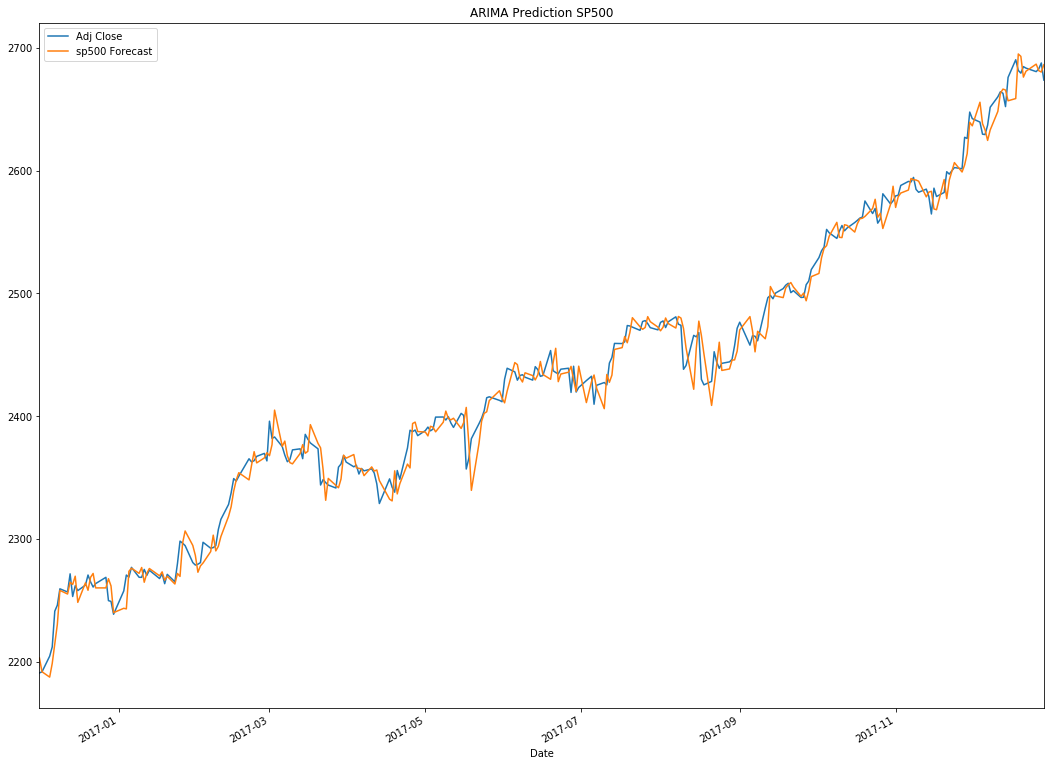

In [532]:
#sp500['Upper band']=sp500['sp500 Forecast'].apply(lambda x: x + (2*rmse))
#sp500['Lower band']=sp500['sp500 Forecast'].apply(lambda x: x -(2*rmse))
sp500[['Adj Close','sp500 Forecast']]["2016-12-01":].plot(figsize=(18,14),title='ARIMA Prediction SP500')

In [533]:
"""
ts_log_diff=sp500['sp500 First Difference'].values
indexs=sp500.index
print(len(ts_log_diff))
print(len(sp500.index))
print(len(forecast.values))
fig = plt.gcf()
fig.set_size_inches(20.5, 12.5)
fig.set_size_inches(20.5, 12.5, forward=True)
plt.plot(sp500.index, ts_log_diff)
plt.plot(sp500.index[2:],forecast.values, color='red')
"""

"\nts_log_diff=sp500['sp500 First Difference'].values\nindexs=sp500.index\nprint(len(ts_log_diff))\nprint(len(sp500.index))\nprint(len(forecast.values))\nfig = plt.gcf()\nfig.set_size_inches(20.5, 12.5)\nfig.set_size_inches(20.5, 12.5, forward=True)\nplt.plot(sp500.index, ts_log_diff)\nplt.plot(sp500.index[2:],forecast.values, color='red')\n"

In [534]:
sp500.tail()

,Adj Close,trend,cycle,RM_21,RM_63,EWMA_21,EWMA_63,RMS_21,sp500 First Difference,sp500 second Difference,sp500 seasonal,sp500 seasonal 1Diff,forecast,sp500 Forecast
Date,,,,,,,,,,,,,,
2017-12-22,2683.340088,2677.100141,6.239947,2650.812872,2592.309539,2652.134103,2597.144291,26.273759,-1.229980,-6.550048,412.580078,-9.459961,-3.760496,2680.809572
2017-12-26,2680.500000,2680.143553,0.356447,2654.530971,2595.224776,2654.712821,2599.749157,24.551321,-2.840088,-1.610108,415.320068,2.739990,3.249882,2686.589970
2017-12-27,2682.620117,2683.185925,-0.565808,2658.397647,2598.011761,2657.249848,2602.338874,22.033598,2.120117,4.960205,421.660156,6.340088,0.792065,2681.292065
2017-12-28,2687.540039,2686.227603,1.312436,2661.278599,2600.828904,2660.003502,2605.001410,21.680949,4.919922,2.799805,423.750000,2.089844,-2.476926,2680.143191
2017-12-29,2673.610107,2689.268918,-15.658811,2663.542411,2603.277317,2661.240466,2607.145432,20.255955,-13.929932,-18.849854,404.730224,-19.019776,-1.402041,2686.137998


In [535]:
#sp500_sec=sp500.copy()
"""
ARIMA Model  calculation done introducing as y_true new day to forecast the mean of the last 3 days EWMA.
we run model seanonal y acfter predit the value for today , we copy the real value  on the Adj Close
rmse =
variance=r2= 

44.05714812255738
0.9877477568569961

44.058542717873365
0.9877469811739543

same values than std 5 days
"""
for i in future_dates_sp500.index:
    offset= sp500.index[-1] - DateOffset(days=3)
    indice=sp500.loc[pd.to_datetime(offset):sp500.index[-1]]['EWMA_21'].mean()
    dates = pd.date_range(i,i)
    #print(indice)
    df = pd.DataFrame(data = {'Adj Close':sp500.loc[pd.to_datetime(offset):sp500.index[-1]]['EWMA_21'].mean(),'trend':0.0, 'cycle':0.0, 'RM_21':0.0, 'RM_63':0.0, 'EWMA_21':0.0, 'EWMA_63':0.0,'RMS_21':0.0, 'sp500 First Difference':0.0, 'sp500 second Difference':0.0,'sp500 seasonal':0.0, 'sp500 seasonal 1Diff':0.0, 'forecast':0.0, 'sp500 Forecast':0.0}, index=dates)
    sp500=pd.concat([sp500,df])
    sp500.drop('sp500 First Difference',axis=1, inplace=True)
    sp500['sp500 First Difference'] = sp500['Adj Close'] - sp500['Adj Close'].shift(1)
    model = ARIMA(sp500['sp500 First Difference'][1:].dropna(),order=(1,1,0))
    #model = ARIMA(sp500['Adj Close'],order=(1,1,0))
    results = model.fit()
    sp500['forecast'] =results.predict()#start='2012-01-03', dynamic= False)
    x=sp500_new.loc[i:i]['Adj Close']
    sp500[i:i]=x
    y=y+1
    print ("round: {} || real: {} and forecast: {}".format(y,x,indice))
    sp500["EWMA_21"] = sp500['Adj Close'].ewm(span=10).mean()
    
    

j:\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
j:\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
j:\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


round: 330 || real: Date
2018-01-02    2695.810059
Name: Adj Close, dtype: float64 and forecast: 2658.301659172576
round: 331 || real: Date
2018-01-03    2713.060059
Name: Adj Close, dtype: float64 and forecast: 2680.1359881769686
round: 332 || real: Date
2018-01-04    2723.98999
Name: Adj Close, dtype: float64 and forecast: 2683.129085524517
round: 333 || real: Date
2018-01-05    2743.149902
Name: Adj Close, dtype: float64 and forecast: 2686.4218032541808
round: 334 || real: Date
2018-01-08    2747.709961
Name: Adj Close, dtype: float64 and forecast: 2690.34737408658
round: 335 || real: Date
2018-01-09    2751.290039
Name: Adj Close, dtype: float64 and forecast: 2706.2682569852536
round: 336 || real: Date
2018-01-10    2748.22998
Name: Adj Close, dtype: float64 and forecast: 2714.1285738970255
round: 337 || real: Date
2018-01-11    2767.560059
Name: Adj Close, dtype: float64 and forecast: 2717.2088202848627
round: 338 || real: Date
2018-01-12    2786.23999
Name: Adj Close, dtype: floa

round: 403 || real: Date
2018-04-18    2708.639893
Name: Adj Close, dtype: float64 and forecast: 2656.0343208662016
round: 404 || real: Date
2018-04-19    2693.129883
Name: Adj Close, dtype: float64 and forecast: 2660.595871144626
round: 405 || real: Date
2018-04-20    2670.139893
Name: Adj Close, dtype: float64 and forecast: 2663.94077861559
round: 406 || real: Date
2018-04-23    2670.290039
Name: Adj Close, dtype: float64 and forecast: 2669.510617140028
round: 407 || real: Date
2018-04-24    2634.560059
Name: Adj Close, dtype: float64 and forecast: 2673.006474227795
round: 408 || real: Date
2018-04-25    2639.399902
Name: Adj Close, dtype: float64 and forecast: 2669.2643969136507
round: 409 || real: Date
2018-04-26    2666.939941
Name: Adj Close, dtype: float64 and forecast: 2666.507945581845
round: 410 || real: Date
2018-04-27    2669.909912
Name: Adj Close, dtype: float64 and forecast: 2665.3999425560223
round: 411 || real: Date
2018-04-30    2648.050049
Name: Adj Close, dtype: flo

In [536]:
print(results.summary())

                                ARIMA Model Results                                 
Dep. Variable:     D.sp500 First Difference   No. Observations:                 1632
Model:                       ARIMA(1, 1, 0)   Log Likelihood               -7174.869
Method:                             css-mle   S.D. of innovations             19.636
Date:                      Thu, 05 Jul 2018   AIC                          14355.739
Time:                              15:30:28   BIC                          14371.931
Sample:                          01-05-2012   HQIC                         14361.746
                               - 06-29-2018                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.0143      0.328      0.044      0.965      -0.629       0.657
ar.L1.D.sp500 First Dif

j:\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
j:\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


In [538]:
sp500.tail()

,Adj Close,EWMA_21,EWMA_63,RMS_21,RM_21,RM_63,cycle,forecast,sp500 Forecast,sp500 seasonal,sp500 seasonal 1Diff,sp500 second Difference,trend,sp500 First Difference
2018-06-25,2717.070068,2754.801523,2717.070068,2717.070068,2717.070068,2717.070068,2717.070068,-10.907154,2717.070068,2717.070068,2717.070068,2717.070068,2717.070068,-37.809815
2018-06-26,2723.060059,2749.030348,2723.060059,2723.060059,2723.060059,2723.060059,2723.060059,20.706911,2723.060059,2723.060059,2723.060059,2723.060059,2723.060059,5.989991
2018-06-27,2699.629883,2740.048445,2699.629883,2699.629883,2699.629883,2699.629883,2699.629883,-21.083788,2699.629883,2699.629883,2699.629883,2699.629883,2699.629883,-23.430176
2018-06-28,2716.310059,2735.732375,2716.310059,2716.310059,2716.310059,2716.310059,2716.310059,14.197333,2716.310059,2716.310059,2716.310059,2716.310059,2716.310059,16.680176
2018-06-29,2718.370117,2732.575601,2718.370117,2718.370117,2718.370117,2718.370117,2718.370117,2718.370117,2718.370117,2718.370117,2718.370117,2718.370117,2718.370117,2718.370117


In [539]:
sp500['sp500 Forecast'] = sp500['forecast']  + sp500['Adj Close'].shift(1)

In [552]:
sp500[2:-2].tail()

,Adj Close,EWMA_21,EWMA_63,RMS_21,RM_21,RM_63,cycle,forecast,sp500 Forecast,sp500 seasonal,sp500 seasonal 1Diff,sp500 second Difference,trend,sp500 First Difference
2018-06-21,2749.760010,2765.032159,2749.760010,2749.760010,2749.760010,2749.760010,2749.760010,-7.635367,2759.684701,2749.760010,2749.760010,2749.760010,2749.760010,-17.560058
2018-06-22,2754.879883,2763.186291,2754.879883,2754.879883,2754.879883,2754.879883,2754.879883,10.761673,2760.521683,2754.879883,2754.879883,2754.879883,2754.879883,5.119873
2018-06-25,2717.070068,2754.801523,2717.070068,2717.070068,2717.070068,2717.070068,2717.070068,-10.907154,2743.972729,2717.070068,2717.070068,2717.070068,2717.070068,-37.809815
2018-06-26,2723.060059,2749.030348,2723.060059,2723.060059,2723.060059,2723.060059,2723.060059,20.706911,2737.776979,2723.060059,2723.060059,2723.060059,2723.060059,5.989991
2018-06-27,2699.629883,2740.048445,2699.629883,2699.629883,2699.629883,2699.629883,2699.629883,-21.083788,2701.976271,2699.629883,2699.629883,2699.629883,2699.629883,-23.430176


In [548]:
from sklearn.metrics import r2_score, mean_squared_error
y_pred=sp500['sp500 Forecast'][2:-2].values
y_true=sp500['Adj Close'][2:-2].values

In [550]:
rmse=mean_squared_error(y_true, y_pred)**0.5
r2=r2_score(y_true, y_pred)
print(rmse)
print(r2)

19.258158537707658
0.9976458060365583


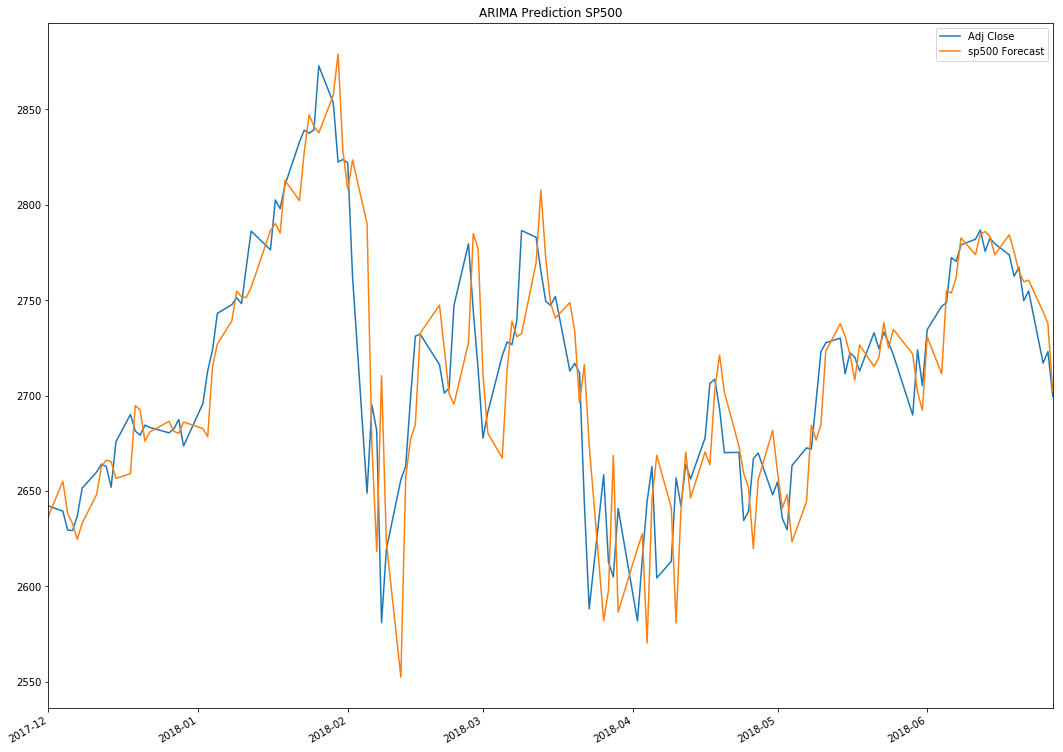

In [554]:
sp500[['Adj Close','sp500 Forecast']]["2017-12-01":"2018-06-27"].plot(figsize=(18,14),title='ARIMA Prediction SP500')

In [555]:
plt.figure()
sp500['Upper band']=sp500['sp500 Forecast'].apply(lambda x: x + (2*rmse))
sp500['Lower band']=sp500['sp500 Forecast'].apply(lambda x: x -(2*rmse))
#sp500[['Adj Close','forecast','Upper band','Lower band']]["2017-12-01":].plot(figsize=(18,14), fontsize=8,color='r', label='Adjusted Close')
#plt.plot(price.index, price, 'k')
indexs=sp500[['Adj Close']]["2017-12-01":"2018-06-27"]
sp500a=sp500[['Adj Close']]["2017-12-01":"2018-06-27"].values
forea=sp500[['sp500 Forecast']]["2017-12-01":"2018-06-27"].values
upper=np.array([sp500[['Upper band']]["2017-12-01":"2018-06-27"].values]).reshape(len(sp500a),)
lower=np.array([sp500[['Lower band']]["2017-12-01":"2018-06-27"].values]).reshape(len(sp500a),)
print(upper)

[2675.28558696 2693.70487726 2676.73423991 2671.52382816 2663.19630139
 2671.65786087 2686.75607709 2701.43307814 2704.75324672 2703.9800292
 2695.16369303 2697.65618384 2733.25101077 2731.10923204 2714.66994982
 2719.47440393 2725.03374737 2719.81334401 2718.76754869 2724.72846174
 2721.23044099 2716.93834766 2753.9827104  2765.57283374 2777.72178865
 2793.28242748 2790.29975565 2789.96704885 2795.30885891 2825.09077626
 2828.69018864 2823.77010767 2851.3459934  2840.74243877 2866.4962789
 2885.62276067 2879.81177894 2876.1974972  2896.03168609 2917.58647196
 2866.63401662 2846.69694022 2862.06433294 2828.62440224 2713.1793139
 2656.87521453 2748.95426305 2661.54525439 2591.00909274 2695.54944622
 2715.69688252 2723.31417615 2771.24077737 2785.959907   2762.97934369
 2739.37126919 2734.03625719 2766.22130511 2823.45726431 2815.40036666
 2750.02091821 2718.95890212 2705.82012702 2751.71489811 2777.503983
 2769.43341239 2771.00731671 2808.03551219 2846.20428362 2810.67053992
 2787.11166

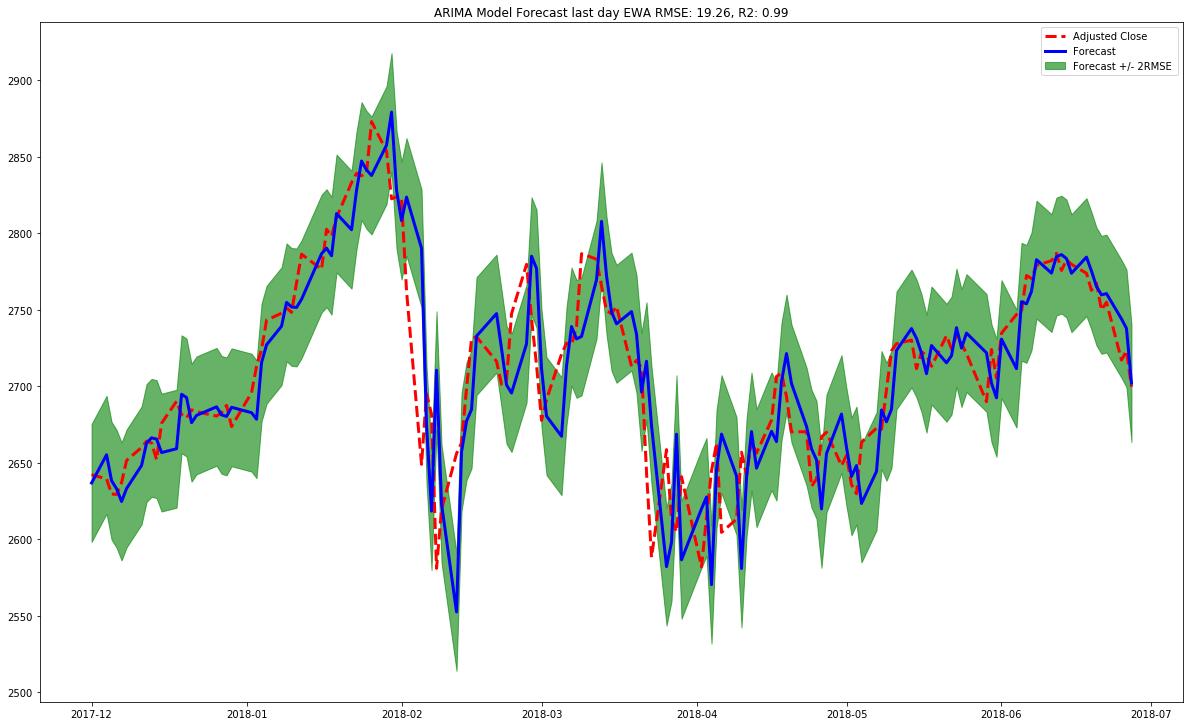

In [568]:
fig = plt.gcf()
fig.set_size_inches(20.5, 12.5)
fig.set_size_inches(20.5, 12.5, forward=True)
#sp500[['Adj Close']]["2017-12-01":].plot(figsize=(18,14), fontsize=8,color='r', label='Adjusted Close')
plt.plot(indexs.index, sp500a,linewidth=3,color='r', label='Adjusted Close', linestyle='dashed')
plt.plot(indexs.index, forea,linewidth=3, label='Forecast', color='b', linestyle='-')
plt.fill_between(indexs.index, upper,lower, color='g', alpha=0.6, label='Forecast +/- 2RMSE ')
#plt.plot(upper,linewidth=2, label='Upper Band', color='g', linestyle=':')
#plt.plot(lower,linewidth=2, label='Lower band', color='g', linestyle=':')
#sp500[['forecast']]["2017-12-01":].plot(style='*',fontsize=8,label='Forecast', Color='b')
#sp500[['Upper band']]["2017-12-01":].plot(style='-',label='Forecast', Color='g')
#sp500[['Lower band']]["2017-12-01":].plot(style='-',label='Forecast', Color='g')

#sp500_new['Adj Close'].plot(label='Real',style='*',fontsize=8)
plt.title('ARIMA Model Forecast last day EWA'+ " RMSE: {}, R2: {}".format("19.26", "0.99"))
plt.legend()
#plt.text(x=10.5, y=10.5 ,s="RMSE: {}, R2: {}".format("19.26", "0.99"))
plt.savefig('Prediction_4.png')
plt.show()